# Machine Learning Project: Covid-19 Prediction
### Case Study
eHealth Africa has carried out an investigation on various factors that could determine if someone has covid-19 or not. The attached data are cases of covid-19 in the town of  Hocus Pocus. You will use your machine learning and data science techniques for predictive modeling and risk analysis, particularly in the healthcare sector. 

### Task
- Data Collection and Preparation
- Exploratory Data Analysis (EDA)
- Feature Engineering
- Choose appropriate machine learning algorithms, such as logistic regression, decision trees, random forests, or gradient boosting machines.
Consider using ensemble methods to improve prediction accuracy.
Model Training
- Use cross-validation to tune hyperparameters and prevent overfitting.
- Model Evaluation
     - Evaluate the models using the testing data with metrics such as accuracy, precision, recall, F1 score, and AUC-ROC.
     - Compare the performance of different models to select the best one.
Use the model to predict the likelihood of COVID-19 cases based on the factors provided.- Develop a flask API, if possible add an HTML to the model
- Deployment

**Note:** 
1. The data cleaning and exploratory analysis is in a separate jupyter notebook,`covid_19_eda.ipynb`
2. Deployment for the model was done using gradio because of ease of use within the note
3. The `covid_model_deployment.ipynb` also contains the app for the prediction

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE 
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df_raw=pd.read_csv("covid_19_clean_dataset.csv")

In [3]:
df=df_raw.copy()


# Feature scaling

In [4]:

scaler = StandardScaler()
df['age'] = scaler.fit_transform(df[['age']])

In [5]:
X=df[df.columns[:-1]].values
y=df.result.values

# Data split

In [6]:


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# Model Selection

In [7]:
from sklearn.ensemble import RandomForestClassifier

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

model = RandomForestClassifier(n_estimators=100, random_state=42,class_weight='balanced')
model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [8]:

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.7408062564007075
[[7577 2298]
 [ 486  380]]
              precision    recall  f1-score   support

           0       0.94      0.77      0.84      9875
           1       0.14      0.44      0.21       866

    accuracy                           0.74     10741
   macro avg       0.54      0.60      0.53     10741
weighted avg       0.88      0.74      0.79     10741



### Observations
- Smote was applied because of imbalance in the dataset. There were more negative results than positives
- Although accuracy is high in this dataset the specificity is a problem. The model overwhelmingly misses out positive cases which is not what we want.
- We could go ahead to use another model but this result alone suggests that we take a look at what might be going on under the hood
- We will check for correlation and see

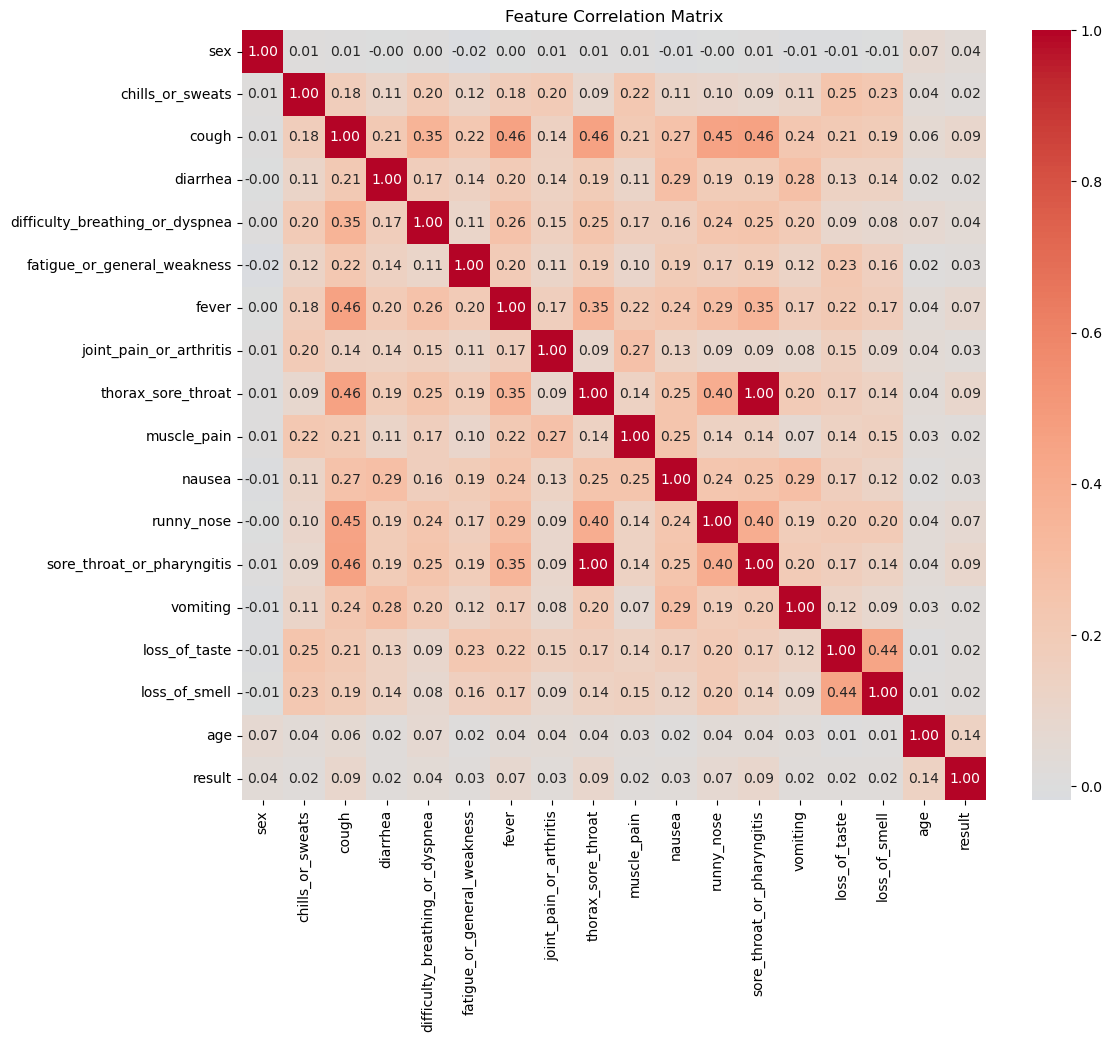

In [9]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

# Specifically check throat-related features
throat_features = ['thorax_sore_throat', 'sore_throat_or_pharyngitis']


The figure above shows that sore_throat_or_pharyngitis is perfectly correlated (corr=) with thorax_sore_throat. Perhaps many of the patients couldn't distinguish between sore throat from thorax or the pharynx when asked for their symtomps.

we do have some features that are related to the other but we have to drop one of the two

In [10]:
X2=df.drop(columns=['result','sore_throat_or_pharyngitis']).values
y2=df.result.values

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, random_state=42, stratify=y
)

In [11]:
smote = SMOTE(random_state=42)
X2_train, y2_train = smote.fit_resample(X2_train, y2_train)

model = RandomForestClassifier(n_estimators=100, random_state=42,class_weight='balanced')
model.fit(X2_train, y2_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [12]:
y_pred = model.predict(X2_test)
print("Accuracy:", accuracy_score(y2_test, y_pred))
print(confusion_matrix(y2_test, y_pred))
print(classification_report(y2_test, y_pred))

Accuracy: 0.7409924588027186
[[7578 2297]
 [ 485  381]]
              precision    recall  f1-score   support

           0       0.94      0.77      0.84      9875
           1       0.14      0.44      0.22       866

    accuracy                           0.74     10741
   macro avg       0.54      0.60      0.53     10741
weighted avg       0.88      0.74      0.79     10741



### Observation
We have droped some features which has quite improve the bearing of the more by far compared to the previous

**Confusion matrix Interpreation**

[[7578 2297] True Negatives: 7578, False Positives: 2297
[ 485  381]] False Negatives: 485, True Positives: 381

Before the model produced 2% recall  which was catastrophic and after it has 44% recall which is quite an improvement

So instead of running the model one by one we we'll processed them all at once while we wait to evaluate.
This way, if we need to alter any parameter, it applies to all

In [13]:
from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import numpy as np

# List of models to test
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=42, scale_pos_weight=len(y2_train[y2_train==0])/len(y2_train[y2_train==1])),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    # 'SVM': SVC(random_state=42, class_weight='balanced', probability=True),
     "SGDC":SGDClassifier(loss='hinge', random_state=42, class_weight='balanced', max_iter=1000)
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    print(f"\n=== Training {name} ===")
    
    # Train model
    model.fit(X2_train, y2_train)
    
    # Predictions
    y_pred = model.predict(X2_test)
    y_pred_proba = model.predict_proba(X2_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    results[name] = {
        'accuracy': accuracy_score(y2_test, y_pred),
        'recall': recall_score(y2_test, y_pred),
        'precision': precision_score(y2_test, y_pred),
        'f1': f1_score(y2_test, y_pred),
        'confusion_matrix': confusion_matrix(y2_test, y_pred)
    }
    
    print(f"Accuracy: {results[name]['accuracy']:.4f}")
    print(f"Recall: {results[name]['recall']:.4f}")
    print(f"Precision: {results[name]['precision']:.4f}")
    print(f"F1-Score: {results[name]['f1']:.4f}")
    print("Confusion Matrix:")
    print(results[name]['confusion_matrix'])


=== Training RandomForest ===
Accuracy: 0.7410
Recall: 0.4400
Precision: 0.1423
F1-Score: 0.2150
Confusion Matrix:
[[7578 2297]
 [ 485  381]]

=== Training LogisticRegression ===
Accuracy: 0.7260
Recall: 0.4885
Precision: 0.1447
F1-Score: 0.2233
Confusion Matrix:
[[7375 2500]
 [ 443  423]]

=== Training XGBoost ===
Accuracy: 0.7370
Recall: 0.4630
Precision: 0.1452
F1-Score: 0.2211
Confusion Matrix:
[[7515 2360]
 [ 465  401]]

=== Training GradientBoosting ===
Accuracy: 0.7458
Recall: 0.4769
Precision: 0.1535
F1-Score: 0.2323
Confusion Matrix:
[[7598 2277]
 [ 453  413]]

=== Training SGDC ===
Accuracy: 0.7826
Recall: 0.3961
Precision: 0.1592
F1-Score: 0.2271
Confusion Matrix:
[[8063 1812]
 [ 523  343]]


## Comments
- Of all they model tested, the best model so far is LogisticRegression
- It detects 48.9% of COVID cases (423 out of 866)
- Misses: 51.1% of COVID cases (443 false negatives)
- It raised false alarms in 2500 healthy people


# Conclusion
>The Logistic Regression model performed the best, detecting approximately half of COVID cases (48.9%) but missing 51.1% of infections. While it successfully identified numerous positives, it also created 2,500 false alarms among healthy persons, indicating that confirmatory testing is required.

In [14]:
# # symtomps associated with respiratory system
# respiratory = ['cough', 'difficulty_breathing_or_dyspnea', 'runny_nose', 
#                'thorax_sore_throat', 'sore_throat_or_pharyngitis']
# df['respiratory_symptom'] = df[respiratory].max(axis=1)

# # Gastrointestinal cluster
# gastro = ['diarrhea', 'nausea', 'vomiting']
# df['gastro_symptom'] = df[gastro].max(axis=1)

# # Neurological / sensory cluster
# neuro = ['loss_of_taste', 'loss_of_smell']
# df['neuro_symptom'] = df[neuro].max(axis=1)

> The above code has been commented out because the engineered features made the models worse than they were initially
> That is why they were completely removed 

In [15]:
# final model training on all data
final_model = LogisticRegression(
    max_iter=1000, 
    random_state=42, 
    class_weight='balanced'
)

final_model.fit(X2, y2)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

## save model for use


In [16]:
import joblib

joblib.dump(final_model, "covid_screening_model.pkl")
joblib.dump(scaler, "age_scaler.pkl")

['age_scaler.pkl']

In [17]:
df.columns[:-1]

Index(['sex', 'chills_or_sweats', 'cough', 'diarrhea',
       'difficulty_breathing_or_dyspnea', 'fatigue_or_general_weakness',
       'fever', 'joint_pain_or_arthritis', 'thorax_sore_throat', 'muscle_pain',
       'nausea', 'runny_nose', 'sore_throat_or_pharyngitis', 'vomiting',
       'loss_of_taste', 'loss_of_smell', 'age'],
      dtype='object')

# Deployment
We will use gradio because it is faster and works within the jupyter notebook

In [18]:
import gradio as gr
import joblib
import numpy as np

# Load model and scaler
model = joblib.load("covid_screening_model.pkl")
scaler = joblib.load("age_scaler.pkl")

# Define prediction function
def predict_covid(sex, chills, cough, diarrhea, dyspnea, fatigue, fever,
                  joint_pain, muscle_pain, nausea, runny_nose, sore_throat, vomiting,
                  loss_of_taste, loss_of_smell, age):
    
    # Scale age
    age_scaled = scaler.transform([[age]])[0][0]
    
    # Prepare input
    input_data = np.array([[sex, int(chills), int(cough), int(diarrhea), int(dyspnea),
                            int(fatigue), int(fever), int(joint_pain), int(muscle_pain),
                            int(nausea), int(runny_nose), int(sore_throat), int(vomiting),
                            int(loss_of_taste), int(loss_of_smell), age_scaled]])
    
    # Prediction
    prob = model.predict_proba(input_data)[0][1]
    pred = model.predict(input_data)[0]
    
    result = "Likely COVID Positive" if pred == 1 else "Likely COVID Negative"
    return f"{result} (Probability: {prob:.2%})"

# Gradio UI
iface = gr.Interface(
    fn=predict_covid,
    inputs=[
        gr.Dropdown([0,1], label="Sex (0=Male, 1=Female)"),
        gr.Checkbox(label="Chills or Sweats"),
        gr.Checkbox(label="Cough"),
        gr.Checkbox(label="Diarrhea"),
        gr.Checkbox(label="Difficulty Breathing or Dyspnea"),
        gr.Checkbox(label="Fatigue or General Weakness"),
        gr.Checkbox(label="Fever"),
        gr.Checkbox(label="Joint Pain or Arthritis"),
        gr.Checkbox(label="Muscle Pain"),
        gr.Checkbox(label="Nausea"),
        gr.Checkbox(label="Runny Nose"),
        gr.Checkbox(label="Sore Throat or Pharyngitis"),
        gr.Checkbox(label="Vomiting"),
        gr.Checkbox(label="Loss of Taste"),
        gr.Checkbox(label="Loss of Smell"),
        gr.Number(label="Age")  # raw age, will be scaled
    ],
    outputs="text",
    title="COVID-19 Screening Tool",
    description="Predicts likelihood of COVID-19 infection based on symptoms and age."
)

iface.launch()


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
